# DP-Image

In [1]:
import os
COLAB = False

In [2]:
if COLAB:
    from pathlib import Path
    #from google.colab import drive
    #drive.mount('/content/drive')
    
    Path("./code").mkdir(exist_ok=True, parents=True)
    !cd code
    
    if not os.path.exists("pixel2style2pixel"):
        !git clone https://github.com/maltetoelle/pixel2style2pixel.git # https://github.com/eladrich/pixel2style2pixel.git
        !cd pixel2style2pixel
    else:
        !cd pixel2style2pixel
        !git pull
    
    !pip install scipy matplotlib tqdm numpy opencv-python pillow tensorboard torch torchvision
    
    !wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
    !sudo unzip ninja-linux.zip -d /usr/local/bin/
    !sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
else:
    os.chdir('..')

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [3]:
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

## Download Pretrained Models

In [4]:
file_id = "1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0"
file_name = "psp_ffhq_encode.pt"
save_path = "./pretrained_models"
Path(save_path).mkdir(exist_ok=True)
if file_name not in os.listdir(save_path):
    download_command = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    !{download_command}

## Define Parameter

In [5]:
model_path = f"./pretrained_models/{file_name}"
image_path = "./notebooks/images/input_img.jpg"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
pprint.pprint(opts)

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}


In [8]:
opts['checkpoint_path'] = model_path
opts['output_size'] = 1024
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: ./pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


## Visualize Input

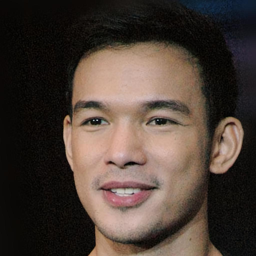

In [33]:
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
original_image.resize((256, 256))

## Align Image

In [10]:
if "shape_predictor_68_face_landmarks.dat" not in os.listdir('.'):
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
if "shape_predictor_68_face_landmarks.dat.bz" not in os.listdir('.'):
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [11]:
def run_alignment(image_path):
    import dlib
    from scripts.align_all_parallel import align_face
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image

Aligned image has shape: (256, 256)


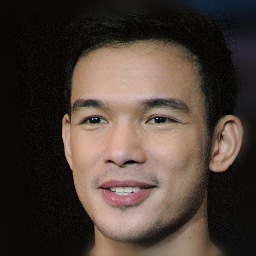

In [12]:
input_image = run_alignment(image_path)
input_image.resize((256, 256))

## Inference

In [13]:
transformed_image = transform(input_image)

In [29]:
NOISE_SCALE = .8
latent_mask = None
with torch.no_grad():
    tic = time.time()
    x = transformed_image.unsqueeze(0).cuda().float()
    result_image = net(x, randomize_noise=False, noise_scale=NOISE_SCALE)[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 0.0749 seconds.


## Visualize Result

In [30]:
input_vis_image = log_input_image(transformed_image, opts)
output_image = tensor2im(result_image)
res = np.concatenate([np.array(input_vis_image.resize((256, 256))),
                      np.array(output_image.resize((256, 256)))], axis=1)

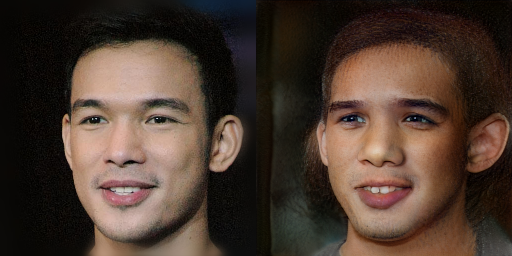

In [31]:
res_image = Image.fromarray(res)
res_image